In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU, Dropout
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage import img_as_ubyte
from keras.preprocessing import image as keras_image
import warnings
warnings.filterwarnings("ignore")

In [3]:
def load_images(base_path):
    data = []
    masked_data = []
    labels = []
    imgdimensions = []  # Store cropped dimensions

    categories = ['COVID-19', 'Non-COVID', 'Normal']

    for category in categories:
        images_path = os.path.join(base_path, category, 'images')
        masks_path = os.path.join(base_path, category, 'lung masks')

        for filename in os.listdir(images_path):
            img_path = os.path.join(images_path, filename)
            mask_path = os.path.join(masks_path, filename)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            img_masked = cv2.bitwise_and(img, img, mask=mask)
            
            # Apply crop to original image and masked image
            crop_percent = 10
            h, w = img.shape
            crop_h = int(h * crop_percent / 100)
            crop_w = int(w * crop_percent / 100)
            img_cropped = img[crop_h:h-crop_h, crop_w:w-crop_w]
            img_masked_cropped = img_masked[crop_h:h-crop_h, crop_w:w-crop_w]

            data.append(img_cropped)  # Cropped original image
            masked_data.append(img_masked_cropped)  # Cropped masked image
            labels.append(category)
            imgdimensions.append((h - 2 * crop_h, w - 2 * crop_w))  # Store cropped dimensions

    return data, masked_data, labels, imgdimensions

# Load images
data, masked_data, labels, imgdimensions = load_images('/kaggle/input/images/Val')

In [4]:

max_height = max(imgdimensions, key=lambda x: x[0])[0]
max_width = max(imgdimensions, key=lambda x: x[1])[1]

input_shape_ = (max_height, max_width)

In [5]:
# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

In [6]:

X_data = np.array(data)
X_masked = np.array(masked_data)
y = np.array(labels)

In [7]:

X_data_train, X_data_val, y_train, y_val = train_test_split(X_data, y_categorical, test_size=0.2, random_state=42)

In [8]:
from imblearn.under_sampling import RandomUnderSampler

X_train_reshaped = X_data_train.reshape(X_data_train.shape[0], -1)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_reshaped, y_train)
X_resampled = X_resampled.reshape(X_resampled.shape[0], *input_shape_)
y_resampled_categorical = to_categorical(y_resampled)


In [9]:
def create_model(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256))
    model.add(LeakyReLU(0.13))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax')) 
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create the model
model = create_model(input_shape_)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_data=(X_data_val, y_val), callbacks=[early_stopping])

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Training Accuracy:", train_acc[-1])
print("Validation Accuracy:", val_acc[-1])

Epoch 1/10
 50/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3623 - loss: 7390.3545

I0000 00:00:1718217971.280193     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4049 - loss: 4687.2642 - val_accuracy: 0.4815 - val_loss: 1290.7539
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4984 - loss: 1133.2458 - val_accuracy: 0.4677 - val_loss: 1186.7605
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5127 - loss: 888.2875 - val_accuracy: 0.4004 - val_loss: 922.4805
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5018 - loss: 838.8615 - val_accuracy: 0.5351 - val_loss: 430.0576
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5435 - loss: 555.7313 - val_accuracy: 0.5609 - val_loss: 253.9482
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5291 - loss: 398.8668 - val_accuracy: 0.5489 - val_loss: 267.0856
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5115 - loss: 395.6018 - val_accuracy: 0.5793 - val_loss: 200.7161
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5157 - loss: 378

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


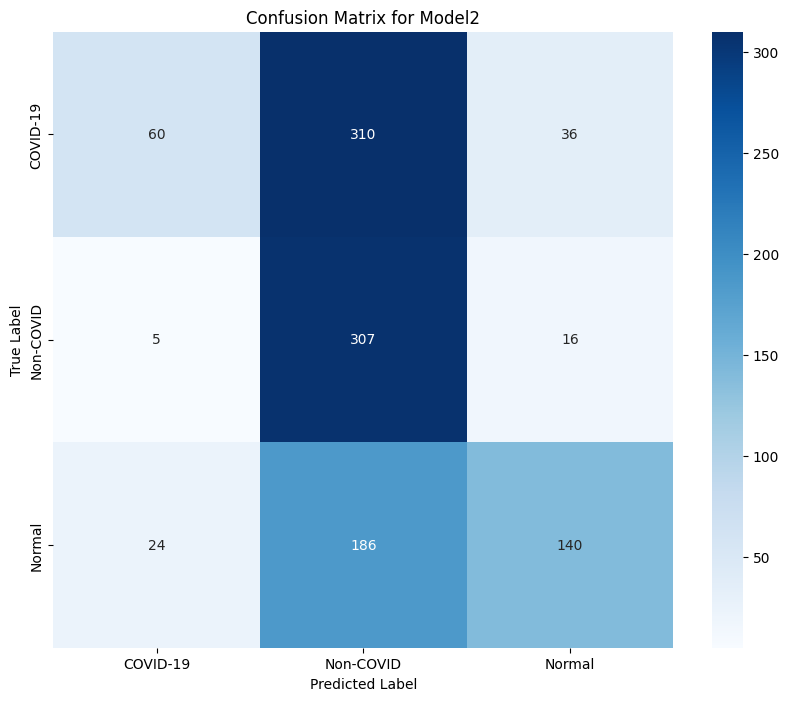

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_data_val)
y_pred_classes = np.argmax(y_pred, axis=1)

y_val_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_val_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Model2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [12]:
def create_model2(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(896))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.1))
    model.add(Dense(512))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='softmax')) 
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create the model
model2 = create_model2(input_shape_)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model2.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_data=(X_data_val, y_val), callbacks=[early_stopping])

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


print("Training Accuracy:", train_acc[-1])
print("Validation Accuracy:", val_acc[-1])

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.3932 - loss: 5348.3022 - val_accuracy: 0.3773 - val_loss: 255.3340
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4808 - loss: 185.7301 - val_accuracy: 0.4124 - val_loss: 156.4368
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4600 - loss: 143.6719 - val_accuracy: 0.3395 - val_loss: 238.5138
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4825 - loss: 129.2353 - val_accuracy: 0.3801 - val_loss: 178.2322
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4622 - loss: 132.8250 - val_accuracy: 0.4880 - val_loss: 94.2121
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5004 - loss: 97.9426 - val_accuracy: 0.4935 - val_loss: 100.9484
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4851 - loss: 102.8013 - val_accuracy: 0.5904 - val_loss: 33.2925
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.503

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


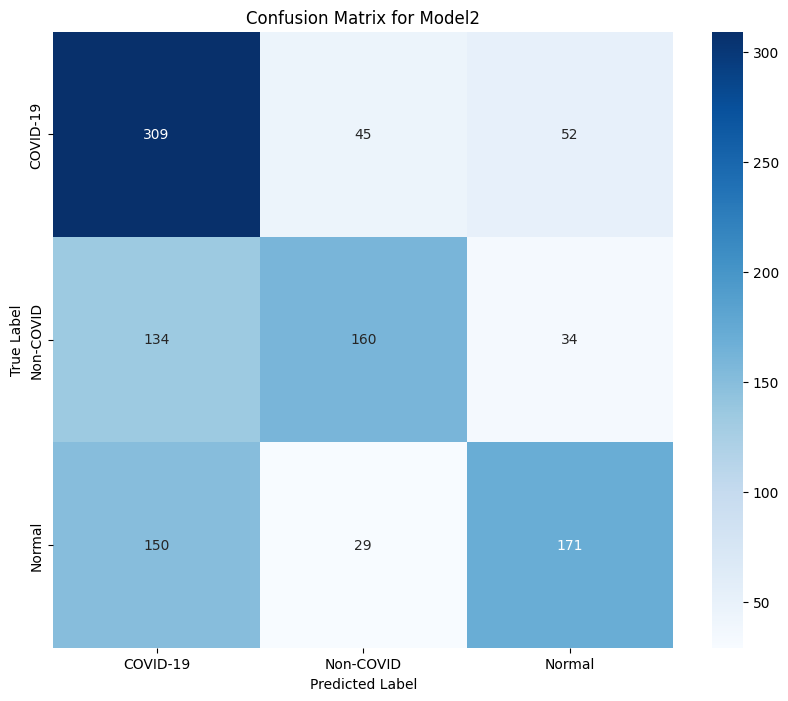

In [23]:
# Make predictions on the validation set
y_pred = model2.predict(X_data_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_val_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Model2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

def create_model3(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.1))
    model.add(Dense(384))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.1))
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='softmax')) 
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model3 = create_model3(input_shape_)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model3.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_data=(X_data_val, y_val), callbacks=[early_stopping])

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Training Accuracy:", train_acc[-1])
print("Validation Accuracy:", val_acc[-1])

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.3463 - loss: 2775.9575 - val_accuracy: 0.3644 - val_loss: 32.7054
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4315 - loss: 55.3403 - val_accuracy: 0.5710 - val_loss: 6.5945
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4482 - loss: 26.2313 - val_accuracy: 0.4197 - val_loss: 12.8145
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4584 - loss: 16.8885 - val_accuracy: 0.5720 - val_loss: 4.4437
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4708 - loss: 14.5294 - val_accuracy: 0.5360 - val_loss: 4.9487
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4764 - loss: 12.2361 - val_accuracy: 0.4197 - val_loss: 8.9993
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4661 - loss: 12.8447 - val_accuracy: 0.5332 - val_loss: 4.5994
Training Accuracy: 0.46989721059799194
Validation Accuracy: 0.5332103371620178


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


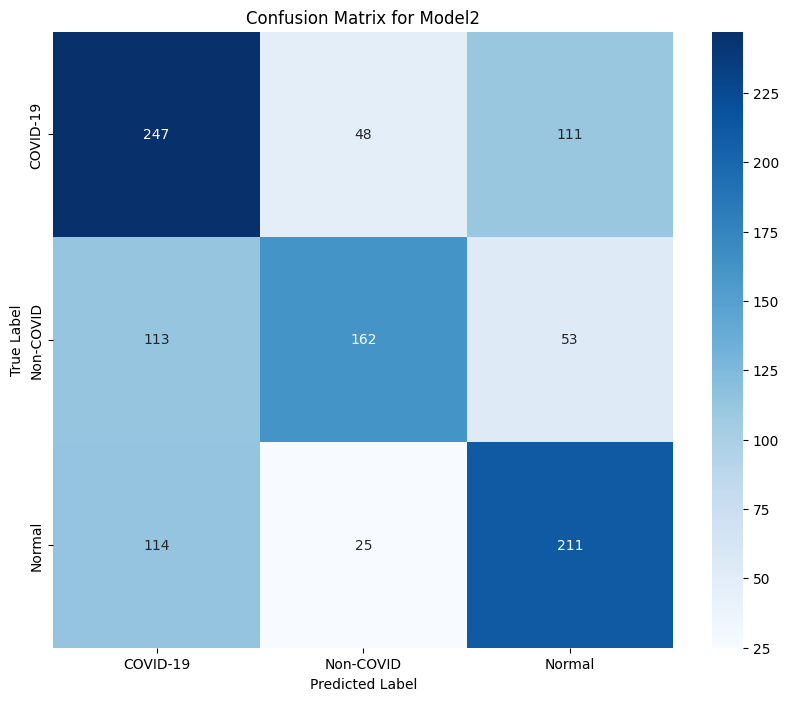

In [24]:

y_pred = model3.predict(X_data_val)
y_pred_classes = np.argmax(y_pred, axis=1)

y_val_classes = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_val_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Model2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [25]:
from tensorflow.keras.callbacks import EarlyStopping

def create_model4(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.1))
    model.add(Dense(512))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.1))
    model.add(Dense(384))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='softmax')) 
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model4 = create_model4(input_shape_)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model4.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_data=(X_data_val, y_val), callbacks=[early_stopping])

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Training Accuracy:", train_acc[-1])
print("Validation Accuracy:", val_acc[-1])

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.3410 - loss: 1231.4641 - val_accuracy: 0.3017 - val_loss: 4.1601
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3767 - loss: 15.0306 - val_accuracy: 0.5074 - val_loss: 1.1022
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3753 - loss: 5.4663 - val_accuracy: 0.4308 - val_loss: 1.3359
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3943 - loss: 3.1031 - val_accuracy: 0.3579 - val_loss: 1.2195
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3724 - loss: 2.5519 - val_accuracy: 0.4041 - val_loss: 1.0527
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4191 - loss: 1.9497 - val_accuracy: 0.3856 - val_loss: 1.1730
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4154 - loss: 1.7749 - val_accuracy: 0.3939 - val_loss: 1.0469
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4375 - loss: 1.5714 - val_accura

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


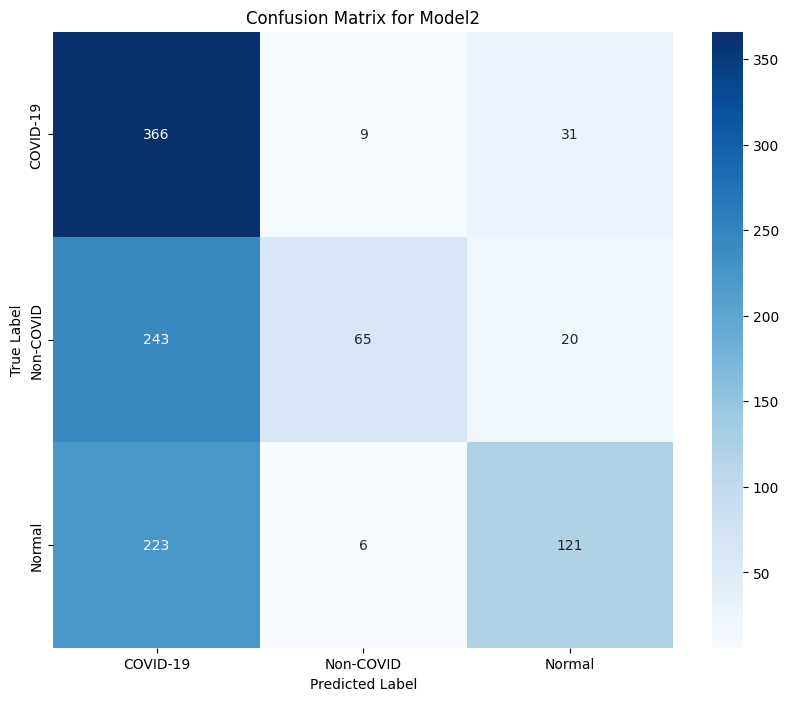

In [26]:

y_pred = model4.predict(X_data_val)
y_pred_classes = np.argmax(y_pred, axis=1)

y_val_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_val_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Model2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [27]:
model3.save("streamlit.h5")

In [30]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def predict_wrapper(images):
    images_for_prediction = np.repeat(np.expand_dims(images, axis=-1), 3, axis=-1)  # Repeat grayscale image along the third axis to create 3 channels
    images_for_prediction = np.concatenate([images_for_prediction, np.zeros_like(images_for_prediction)], axis=-1)  # Append 5 empty channels
    images_preprocessed = images_for_prediction.astype('float32') / 255.0  # Normalize pixel values
    return model2.predict(images_preprocessed)

explainer = lime_image.LimeImageExplainer()

explanations = []
for i in range(X_data_val.shape[0]):
    image_for_lime = np.repeat(np.expand_dims(X_data_val[i], axis=-1), 3, axis=-1)
    explanation = explainer.explain_instance(image_for_lime, predict_wrapper, top_labels=3, hide_color=0, num_samples=1000)
    explanations.append(explanation)

temp = np.zeros_like(X_data_val[0])
mask = np.zeros_like(X_data_val[0])
for explanation in explanations:
    temp_, mask_ = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    temp += temp_
    mask += mask_

temp /= len(explanations)
mask /= len(explanations)

plt.subplot(1, 2, 1)
plt.imshow(X_val[0], cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='gray')
plt.title('LIME Explanation')

plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(10, 206, 206, 3, 6), dtype=float32). Expected shape (None, 206, 206), but input has incompatible shape (10, 206, 206, 3, 6)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(10, 206, 206, 3, 6), dtype=float32)
  • training=False
  • mask=None

Since tuning the model resulted in poor trials, I've decided to continue with the best model from my previous rendition since its accuracies were much higher
